# Image Classification with Python & Scikit-learn

This demo is from https://gogul09.github.io/software/image-classification-python.  It uses scikit-learn to classify images of flowers.  The code runs quickly, but accuracy is low, primarily due to the small training dataset we'll use.

We'll use the [FLOWERS17 dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/17/) from Univ. of Oxford.  It has 17 species of flowers, 80 images of each, for a total of 1360 images.

First we'll set up the modules we'll need.

In [1]:
%matplotlib inline

# organize imports
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py

# fixed-sizes for image
fixed_size = tuple((256, 256))

# path to training data
train_path = "dataset/train"

# no.of.trees for Random Forests
num_trees = 100

# bins for histogram
bins = 8

# train_test_split size
test_size = 0.10

# seed for reproducing same results
seed = 9

We need to extract some global features (features that describe the image as a whole).  We'll focus on 3 features:

* Shape (Hu moments)
* Texture (Haralick texture)
* Color (Color histogram)

Below we have 3 functions that make use of OpenCV and Mahotas to extract each of these features.  For the Shape and Texture functions we first convert the image to grayscale and then 

In [2]:
# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

We're going to genereate a list of training labels.  The code assumes that the images are organised as follows:

```
|--image-classification (folder)
|--|--dataset (folder)
|--|--|--train (folder)
|--|--|--|--cowbell (folder)
|--|--|--|--|--image_1.jpg
|--|--|--|--|--image_2.jpg
|--|--|--|--|--...
|--|--|--|--tulip (folder)
|--|--|--|--|--image_1.jpg
|--|--|--|--|--image_2.jpg
|--|--|--|--|--...
```

We'll create a label for each flower species.

In [3]:
# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()
print(train_labels)

# empty lists to hold feature vectors and labels
global_features = []
labels = []

i, j = 0, 0
k = 0

# num of images per class
images_per_class = 80

['bluebell', 'buttercup', 'coltsfoot', 'cowslip', 'crocus', 'daffodil', 'daisy', 'dandelion', 'fritillary', 'iris', 'lilyvalley', 'pansy', 'snowdrop', 'sunflower', 'tigerlily', 'tulip', 'windflower']


We'll loop over each label and iterate through each of the images in that directory.  For each image we'll resize it to fixed size and use our functions from above to extract features.  All of the features are combined into a single list.

In [4]:
%%time
# loop over the training data sub-folders
for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join(train_path, training_name)

    # get the current training label
    current_label = training_name

    k = 1
    # loop over the images in each sub-folder
    name='image_'
    for x in range(1,images_per_class+1):
        # get the image file name
        file = dir + "/" + name + str(x) + ".jpg"
     
        # read the image and resize it to a fixed-size
        image = cv2.imread(file)
        image = cv2.resize(image, fixed_size)

        ####################################
        # Global Feature extraction
        ####################################
        fv_hu_moments = fd_hu_moments(image)
        fv_haralick   = fd_haralick(image)
        fv_histogram  = fd_histogram(image)

        ###################################
        # Concatenate global features
        ###################################
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

        # update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)

        i += 1
        k += 1
    print("[STATUS] processed folder: {}".format(current_label))
    j += 1

print("[STATUS] completed Global Feature Extraction...")

[STATUS] processed folder: bluebell
[STATUS] processed folder: buttercup
[STATUS] processed folder: coltsfoot
[STATUS] processed folder: cowslip
[STATUS] processed folder: crocus
[STATUS] processed folder: daffodil
[STATUS] processed folder: daisy
[STATUS] processed folder: dandelion
[STATUS] processed folder: fritillary
[STATUS] processed folder: iris
[STATUS] processed folder: lilyvalley
[STATUS] processed folder: pansy
[STATUS] processed folder: snowdrop
[STATUS] processed folder: sunflower
[STATUS] processed folder: tigerlily
[STATUS] processed folder: tulip
[STATUS] processed folder: windflower
[STATUS] completed Global Feature Extraction...
CPU times: user 1min 16s, sys: 2min 11s, total: 3min 27s
Wall time: 54.4 s


Once we've done our feature extraction we need to normalise the data (to prevent one feature from possibly dominating).  Then we save our data in an HDF5 format

In [5]:
%%time
# get the overall feature vector size
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

# get the overall training label size
print("[STATUS] training Labels {}".format(np.array(labels).shape))

# encode the target labels
targetNames = np.unique(labels)
le = LabelEncoder()
target = le.fit_transform(labels)
print("[STATUS] training labels encoded...")

# normalize the feature vector in the range (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")

print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

# save the feature vector using HDF5
h5f_data = h5py.File('output/data.h5', 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label = h5py.File('output/labels.h5', 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

print("[STATUS] end of training..")

[STATUS] feature vector size (1360, 532)
[STATUS] training Labels (1360,)
[STATUS] training labels encoded...
[STATUS] feature vector normalized...
[STATUS] target labels: [ 0  0  0 ... 16 16 16]
[STATUS] target labels shape: (1360,)
[STATUS] end of training..
CPU times: user 70 ms, sys: 220 ms, total: 290 ms
Wall time: 88.7 ms


Now it's time to train.  We're going to test a number of different models in this example:

* Logistic Regression
* Linear Discriminant Analysis
* K-Nearest Neighbors
* Decision Trees
* Random Forests
* Gaussian Naive Bayes
* Support Vector Machine


In [6]:
# import the necessary packages
import h5py
import numpy as np
import os
import glob
import cv2
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib

# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=9)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=9)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=9)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=9)))

# variables to hold the results and names
results = []
names = []
scoring = "accuracy"

# import the feature vector and trained labels
h5f_data = h5py.File('output/data.h5', 'r')
h5f_label = h5py.File('output/labels.h5', 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")

[STATUS] features shape: (1360, 532)
[STATUS] labels shape: (1360,)
[STATUS] training started...


We can use scikit-learn's built-in function to split our data into testing and training data.

In [7]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))
print("Train labels: {}".format(trainLabelsGlobal.shape))
print("Test labels : {}".format(testLabelsGlobal.shape))

[STATUS] splitted train and test data...
Train data  : (1224, 532)
Test data   : (136, 532)
Train labels: (1224,)
Test labels : (136,)


We'll do a comparison of ML algorithms using a technique called [K-Fold Cross Validation](https://towardsdatascience.com/cross-validation-70289113a072).  Basically, we partition our data in `K` bins, and use some of the data for testing/validation and the rest for training.  The models are run multiple times and averaged.

A plot showing the accuracy of each algorithm is shown after our cross-validation is complete

LR: 0.498447 (0.051530)
LDA: 0.460003 (0.038039)
KNN: 0.361962 (0.028361)
CART: 0.443576 (0.024273)
RF: 0.649454 (0.031216)
NB: 0.366813 (0.032059)
SVM: 0.043343 (0.027239)


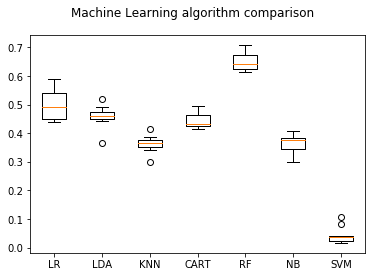

CPU times: user 36.7 s, sys: 7.41 s, total: 44.1 s
Wall time: 32.4 s


In [8]:
%%time
# filter all the warnings
import warnings
warnings.filterwarnings('ignore')

# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

Our accuracies are not great.  The best we have is the Random Forest with an accuracy of **~65%**.  This is mainly due to the low number of images we use.

Let's see how well the Random Forest model works on some real data.  I downloaded an image for each of the 17 species (they're in the `dataset/test` directory.  I tried to not use the top hits in Google (as some of those may be in our training dataset).

We'll print the predictied species on the image.

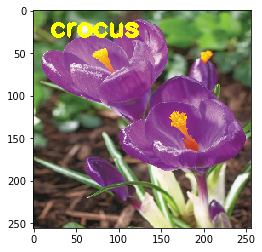

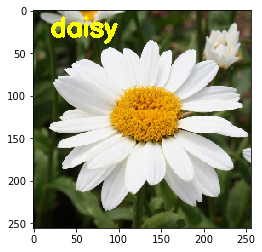

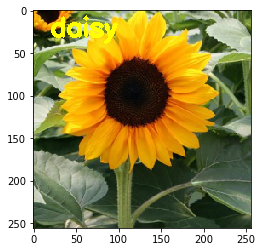

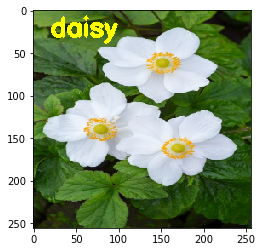

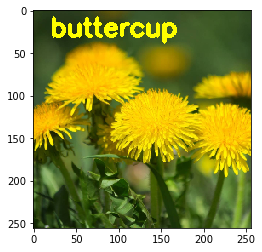

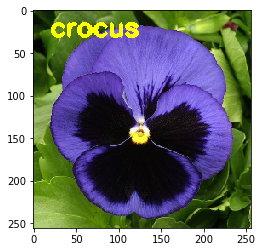

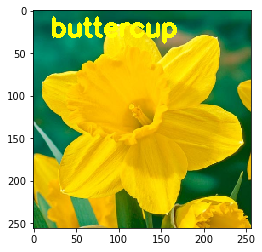

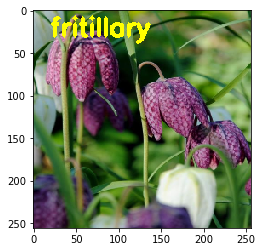

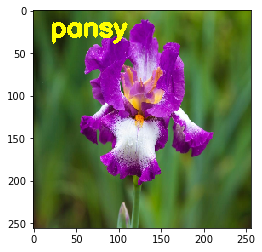

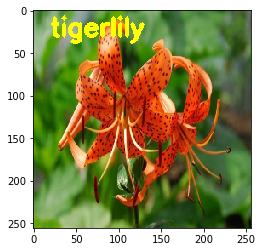

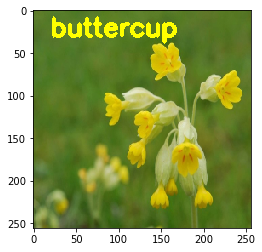

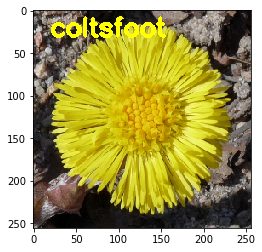

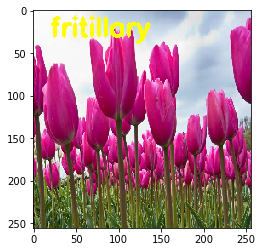

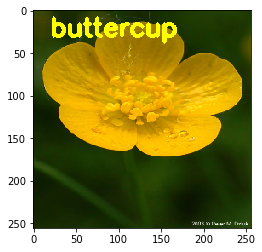

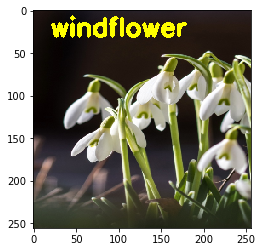

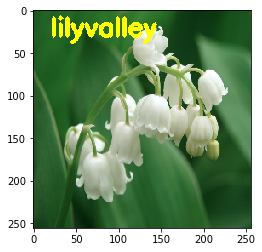

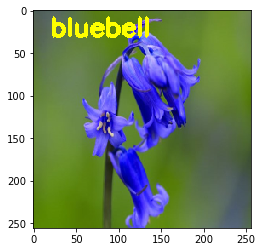

In [9]:
# to visualize results
import matplotlib.pyplot as plt

# create the model - Random Forests
clf  = RandomForestClassifier(n_estimators=100, random_state=9)

# fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)

# path to test data
test_path = "dataset/test"

# file_write_obj = open("result1.txt", 'w')

# loop through the test images
for file in glob.glob(test_path + "/*.jpg"):
    
    # read the image
    image = cv2.imread(file)    
    # print(file)

    # resize the image
    image = cv2.resize(image, fixed_size)

    ####################################
    # Global Feature extraction
    ####################################
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)

    ###################################
    # Concatenate global features
    ###################################
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

    # predict label of test image
    prediction = clf.predict(global_feature.reshape(1,-1))[0]

    # show predicted label on image
    cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

    # display the output image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    

Not too bad, but not great.  